In [1]:
import os
import json
import numpy as np
import cv2 as cv    
import matplotlib.pyplot as plt

In [3]:
# Test image
img = cv.imread('data/laodikeia/img/1.jpg')

# Annotation
with open('data/laodikeia/ann/77.json') as f:
    ann = json.load(f)

(598, 711, 3)


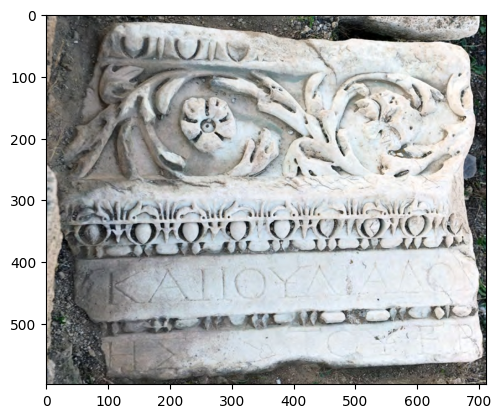

In [4]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

print(img.shape)

/home/tenzing/apollo/avc/projects/archaeology/.myvenv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(888, 1056, 3)


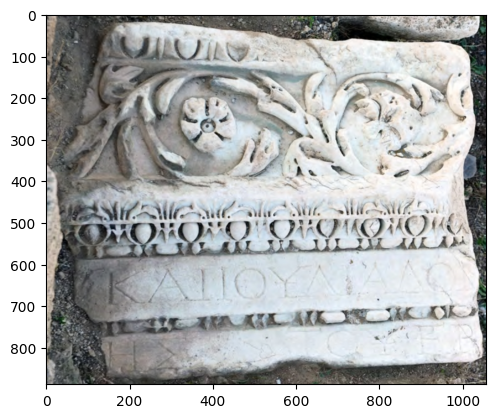

In [5]:
import albumentations as A
from albumentations.augmentations.geometric.resize import Resize
from albumentations.core.composition import Compose
from albumentations.core.transforms_interface import ImageOnlyTransform
import cv2 

# Define target size
target_height = 704
target_width = 1056

transform = A.Compose([
    A.LongestMaxSize(max_size=max(target_height, target_width)),  # Resize longest side
    A.PadIfNeeded(min_height=target_height, min_width=target_width, border_mode=cv2.BORDER_CONSTANT, value=0),  # Add padding
])

transformed = transform(image=img)
img = transformed['image']
print(img.shape)

# show the image
plt.imshow(img)
plt.show()

In [17]:
objects = ann['objects']
print(len(objects))
print(objects[0]['bitmap']['origin'])

7
[109, 96]


In [18]:
import numpy as np
import cv2, zlib, base64, io
from PIL import Image

def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.fromstring(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


/tmp/ipykernel_9164/2833369198.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  n = np.fromstring(z, np.uint8)


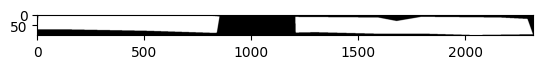

In [19]:
mask = base64_2_mask(objects[0]['bitmap']['data'])
print(mask)
plt.imshow(mask, cmap='gray')

In [14]:
def apply_and_resize_mask(img, mask, origin, resize_shape=(224, 224), color=(0, 255, 0, 0.5)):
    cols, rows = origin  # Origin coordinates in the original image
    rows_mask, cols_mask = mask.shape  # Shape of the mask

    img_with_mask = img.copy() # Copy of the original image

    # ROI
    img_with_mask[rows:rows + rows_mask, cols:cols + cols_mask][mask] = color  # Color set to green where mask is `True`

    # Resize image
    img_with_mask = cv.resize(img_with_mask, resize_shape)

    return img_with_mask

In [20]:
img_shape = img.shape

colors = [[0,225,0], [0,0,225], [225,0,0], [0,225,225], [225,0,225], [225,225,0], [0,0,0], [225,225,225]]

for i, obj in enumerate(objects):
    mask = base64_2_mask(obj['bitmap']['data'])
    img_with_mask = apply_and_resize_mask(img, mask, obj['bitmap']['origin'], resize_shape=(img_shape[1], img_shape[0]), color=colors[i%len(colors)])
    img = img_with_mask.copy()

    cv.putText(img_with_mask, str(i), (obj['bitmap']['origin'][1], obj['bitmap']['origin'][0]), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)

img_with_mask = img_with_mask[150:500, 10:1000]
img_crop = img_with_mask.copy()


plt.imshow(img_with_mask)
plt.savefig('test.png')

/tmp/ipykernel_9164/2833369198.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  n = np.fromstring(z, np.uint8)


IndexError: boolean index did not match indexed array along axis 1; size of axis is 947 but size of corresponding boolean axis is 2319

[  0   0 225]


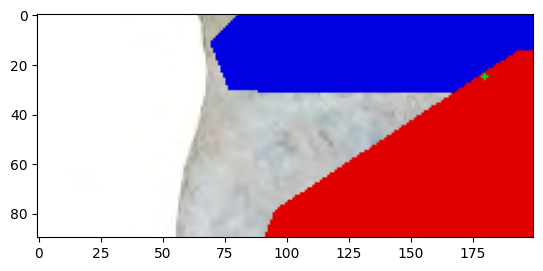

In [33]:
img_crop = img_with_mask[10:100, :200]
# plot circle
cv.circle(img_crop, (180, 25), 1, (0, 225, 0), -1)
plt.imshow(img_crop)

print(img_crop[20, 175])

Image Size (808, 2592, 3)
Mask Size (808, 2592)


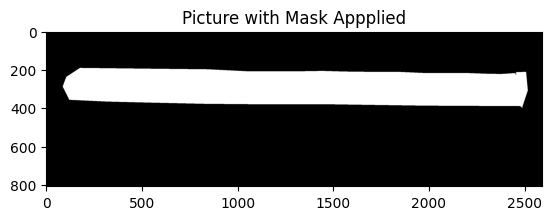

In [71]:
img = Image.open('dataset/images/169.jpg')
mask = Image.open('dataset/masks/169.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

# convert to img to numpy array
img = np.asarray(img)
mask = np.asarray(mask)
# Create binary images for specific classes
img_class_1 = (mask == 12).astype(np.uint8) * 255  # Class 12 
img_class_2 = (mask == 15).astype(np.uint8) * 255  # Class 15

plt.imshow(img_class_1, cmap='gray')

plt.title('Picture with Mask Appplied')
plt.show()
# 

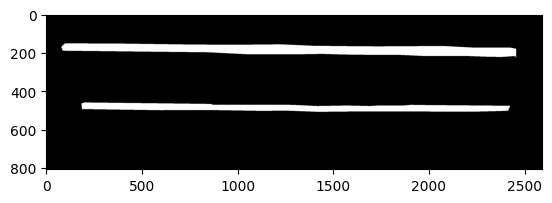

In [72]:
plt.imshow(img_class_2, cmap='gray')
plt.show()

In [ ]:
# No overlapping
print(np.logical_and(img_class_1, img_class_2).sum())


0


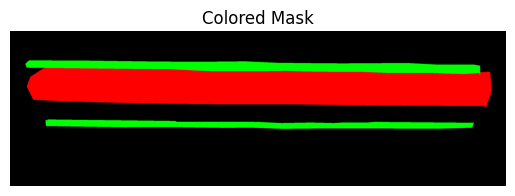

In [76]:
# Initialize a color image with the same height and width as the mask
color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)


# Set colors for specific classes
color_class_1 = [255, 0, 0]  # Red for class 12
color_class_2 = [0, 255, 0]  # Green for class 15

# Assign colors to the corresponding pixels
color_mask[mask == 12] = color_class_1  # Class 12
color_mask[mask == 15] = color_class_2  # Class 15

# Display the resulting color mask
plt.imshow(color_mask)
plt.title("Colored Mask")
plt.axis('off')
plt.show()

In [78]:
for i, obj in enumerate(objects):
    print(f"object={i+1}, {obj['classTitle']}")

object=1, Ionic kyma decoration
object=2, Bead-and-reel (double double)
object=3, Scroll pattern (large)
object=4, Anthemion (small & soffit & top moulding architrave)
object=5, Bead-and-reel (double double)
object=6, Inscription
object=7, Ionic kyma decoration


In [75]:
# count green pixels
green = np.all(img_with_mask == [0, 255, 0], axis=-1)
print(np.sum(green))

size = 224*224
print(size)

# Percentage of green pixels
print(np.sum(green)/size * 100, "%")

7
50176
0.013950892857142856 %


In [5]:
img = cv.imread('dataset/masks/169.png')

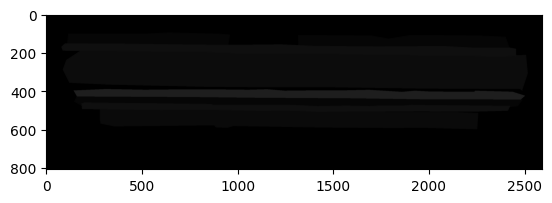

In [6]:
plt.imshow(img)

In [24]:
for i in os.listdir("dataset/masks"):
    img = cv.imread(f'dataset/masks/{i}')
    img = cv.resize(img, (224, 224))
    # print("Min value: ", np.min(img))
    # print("Max value: ", np.max(img))
    value = np.max(img)
    if value > 36:
        print("Max value is greater than 36")
        break

    if value < 0:
        print("Min value is less than 0")
        break
